**W266 DETOX BART FROM MON**

In [1]:
# Install these packages if running from colab
!pip install tensorflow-datasets --quiet
!pip install pydot --quiet
!pip install transformers --quiet

# install huggingface datasets
!pip install datasets --quiet

! pip install rouge-score nltk --quiet
! pip install huggingface_hub --quiet

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re

In [3]:
# get paradetox dataset
# the toxic parallel dataset
from datasets import load_dataset, load_metric

dataset = load_dataset("SkolkovoInstitute/paradetox", split="train")
dataset = dataset.train_test_split(test_size=0.1, shuffle=True)
metric = load_metric("rouge")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  import sys


In [4]:
dataset


DatasetDict({
    train: Dataset({
        features: ['en_toxic_comment', 'en_neutral_comment'],
        num_rows: 17789
    })
    test: Dataset({
        features: ['en_toxic_comment', 'en_neutral_comment'],
        num_rows: 1977
    })
})

In [5]:
metric

Metric(name: "rouge", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}, usage: """
Calculates average rouge scores for a list of hypotheses and references
Args:
    predictions: list of predictions to score. Each prediction
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    rouge_types: A list of rouge types to calculate.
        Valid names:
        `"rouge{n}"` (e.g. `"rouge1"`, `"rouge2"`) where: {n} is the n-gram based scoring,
        `"rougeL"`: Longest common subsequence based scoring.
        `"rougeLSum"`: rougeLsum splits text using `"
"`.
        See details in https://github.com/huggingface/datasets/issues/617
    use_stemmer: Bool indicating whether Porter stemmer should be used to strip word suffixes.
    use_aggregator: Return aggregates if this is set to True
Retu

In [6]:
pd.DataFrame(dataset['train'])

,en_toxic_comment,en_neutral_comment
0,"if we under react , we are fucked .",If we under react we will be in danger
1,my hair is super longgg o it touches my ass,my hair is super longgg
2,im starting to think repubs are a bunch of sof...,I am starting to think repubs are soft and sca...
3,so you think the fool we call our president ac...,so you think our president actually has respec...
4,"this shit is getting crazy , what 's next no w...","This is getting crazy, what’s next no wwii games?"
...,...,...
17784,"dog would get his ass kicked , but the effects...","dog would fight better , but the effects of be..."
17785,what a vivid imagination ! enjoy your shit life,What a vivid imagination! Enjoy your bad life.
17786,they 're fucked up by both parties .,they are messed up by both parties
17787,friday can fuck right off .,Friday can leave


In [7]:
model_checkpoint = "facebook/bart-large"

In [ ]:
from transformers import BartTokenizer, TFBartForConditionalGeneration

model = TFBartForConditionalGeneration.from_pretrained(model_checkpoint)
tokenizer = BartTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at facebook/bart-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

In [ ]:
## Encode detox train_texts with BART tokenizer
max_length = 25
#max_label_length = 128

def preprocess_function(examples):
    inputs = [doc for doc in examples['en_toxic_comment']]
    model_inputs = tokenizer(inputs, max_length=max_length, truncation=True, padding=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples['en_neutral_comment'], max_length=max_length, truncation=True, padding=True
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
# tokenize the detox dataset
tokenized_datasets = dataset.map(preprocess_function, batched=True)

In [ ]:
# hyperparameters
batch_size = 8
learning_rate = 2e-5
weight_decay = 0.01
num_train_epochs = 1

In [ ]:
# convert the train and the test tokenized dataset to TF dataset
train_dataset = model.prepare_tf_dataset(
    tokenized_datasets['train'],
    batch_size = batch_size,
    shuffle=True,
    #collate_fn=data_collator,
)

validation_dataset = model.prepare_tf_dataset(
    tokenized_datasets['test'],
    batch_size = batch_size,
    shuffle = False,
    #collate_fn=data_collator,
)

AttributeError: ignored

In [ ]:
# model compile
from transformers import AdamWeightDecay
import tensorflow as tf

optimizer = AdamWeightDecay(learning_rate = learning_rate, 
                            weight_decay_rate = weight_decay
                            )
model.compile(optimizer = optimizer)

#"cosine_similarity"
#loss=tf.keras.losses.CosineSimilarity(axis=1)
#metrics=[tf.keras.metrics.CosineSimilarity(axis=1)]

In [ ]:
# model fit
bart_model_history = model.fit(
    train_dataset, 
    validation_data = validation_dataset,
    batch_size = batch_size,
    epochs=num_train_epochs
)

In [ ]:
# using detox pretrained
from transformers import BartForConditionalGeneration, AutoTokenizer
base_model_name = 'facebook/bart-base'
model_name = 'SkolkovoInstitute/bart-base-detox'
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
model = BartForConditionalGeneration.from_pretrained(model_name) 

Downloading:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558M [00:00<?, ?B/s]

**BERT TWEET MODEL FROM ANSTONIA**

In [11]:
!pip install datasets
!pip install transformers
import pandas as pd
import transformers
from datasets import load_dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint 

In [13]:
from transformers import BertTokenizer, TFBertModel

In [14]:
url = 'https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv'
df = pd.read_csv(url, index_col=0)
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


# Field Description from  Davidson et.al github

count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

In [5]:
df.describe()

,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


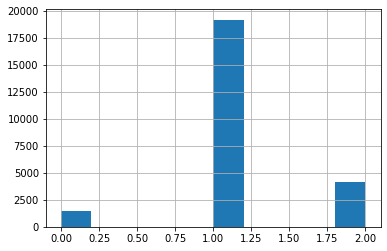

In [6]:
df['class'].hist()

Very large skew towards offensive langauge in the dataset

In [15]:
training_tweets, testing_tweets = train_test_split(df, test_size=0.2, random_state=25)
valid_tweets, testing_tweets = train_test_split(testing_tweets, test_size = 0.5, random_state=25)

In [16]:
print(f"No. of training examples: {training_tweets.shape[0]}")
print(f"No. of validation examples: {valid_tweets.shape[0]}")
print(f"No. of testing examples: {testing_tweets.shape[0]}")

No. of training examples: 19826
No. of validation examples: 2478
No. of testing examples: 2479


In [17]:
training_tweets['tweet'].apply(lambda x: len(x)).mean()

85.46645818622011

In [18]:
#make it easier to use a variety of BERT subword models
# model_checkpoint = 'bert-base-cased'
model_checkpoint = "vinai/bertweet-base"

In [19]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained("vinai/bertweet-base")

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFBertModel: ['roberta', 'lm_head']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
max_length = 100

In [ ]:
list(training_tweets['tweet'].apply(lambda x: str(x)))

In [22]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bert_tokenizer(list(training_tweets['tweet'].apply(lambda x: str(x))), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(list(valid_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(list(testing_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [23]:
def create_bert_multiclass_model(checkpoint = model_checkpoint,
                                hidden_size = 201, 
                                dropout=0.3,
                                learning_rate=0.00005):
  """
  Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
  """
  bert_model = TFBertModel.from_pretrained(checkpoint)                                              
  ### YOUR CODE HERE

  input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
  token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

  bert_inputs = {'input_ids': input_ids,
  'token_type_ids': token_type_ids,
  'attention_mask': attention_mask
  }      

  bert_out = bert_model(bert_inputs)

  pooled_token = bert_out[1]

  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)


  hidden = tf.keras.layers.Dropout(dropout)(hidden)  


  classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer')(hidden)

  classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

  classification_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
      metrics=['accuracy'])


  ### END YOUR CODE
  return classification_model

In [24]:
pooled_bert_model = create_bert_multiclass_model(checkpoint = model_checkpoint)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFBertModel: ['roberta', 'lm_head']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
pooled_bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 100)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 100)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 100)]       0           []                               
 er)                                                                                              
                                                                                              

In [32]:
####### FROM keras_training_with_limited_ram.ipynb #############
####### MOUNT DRIVE FOLDER TO SAVE CHECKPOINTS TO DRIVE AND NOT TEMP DISK SPACE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# CHANGE THIS TO THE PATH IN YOUR OWN DRIVE WHERE YOU WANT TO SAVE CHECKPOINTS
!ls drive/MyDrive/Colab_Notebooks

 a1_draft.ipynb			        __pycache__
'a2 answers'			        QuestionAnswering_test.ipynb
 data.py			        Summarization_test.ipynb
'HWBasedModel (1).ipynb'	        Text_classification.ipynb
 HWBasedModel.ipynb		        Untitled
 image_captioning.ipynb		        Untitled0.ipynb
 model_checkpoints		        w266-detox-bart.ipynb
 Multiclass_text_classification.ipynb  'W266 Evaluation Draft.ipynb'


In [26]:
# CHANGE checkpoint_dir TO THE PATH IN YOUR OWN DRIVE WHERE YOU WANT TO SAVE CHECKPOINTS

checkpoint_dir = 'drive/MyDrive/Colab_Notebooks/model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

In [23]:
###### from keras_training_with_limited_ram.ipynb, modified for this 

### DO WE NEED THE DATA GENERATOR?????????????
pooled_bert_model_history = pooled_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  np.array(training_tweets['class']),   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  np.array(valid_tweets['class'])),    
                                                  batch_size=8, 
                                                  epochs=1,
                                                  callbacks=[model_checkpoint_callback])  


2479/2479 [==============================] - 547s 212ms/step - loss: 0.7030 - accuracy: 0.7705 - val_loss: 0.6512 - val_accuracy: 0.7776


In [18]:
##It takes 10 to 14 minutes to complete an epoch when using a GPU
#pooled_bert_model_history = pooled_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
#                                                  np.array(training_tweets['class']),   
#                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
#                                                  np.array(valid_tweets['class'])),    
#                                                  batch_size=8, 
#                                                  epochs=1)  

2479/2479 [==============================] - 554s 215ms/step - loss: 0.6919 - accuracy: 0.7722 - val_loss: 0.6495 - val_accuracy: 0.7776


In [19]:
score = pooled_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask], 
                                                  np.array(testing_tweets['class'])) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

78/78 [==============================] - 17s 221ms/step - loss: 0.6561 - accuracy: 0.7773
Test loss: 0.656058132648468
Test accuracy: 0.7773295640945435


In [ ]:
#run and capture all predictions from our test set using model.predict
### YOUR CODE HERE
predictions = pooled_bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
### END YOUR CODE

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions = tf.argmax(predictions, axis=-1)
predictions

78/78 [==============================] - 19s 212ms/step


<tf.Tensor: shape=(2479,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 1, 1])>

In [ ]:
print(classification_report(testing_tweets['class'], predictions.numpy(), target_names=['0','1','2']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       139
           1       0.78      1.00      0.87      1927
           2       0.00      0.00      0.00       413

    accuracy                           0.78      2479
   macro avg       0.26      0.33      0.29      2479
weighted avg       0.60      0.78      0.68      2479



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **EVALUATION - Using pre-trained**

In [4]:
# using detox pretrained
from transformers import BartForConditionalGeneration, AutoTokenizer
base_model_name = 'facebook/bart-base'
model_name = 'SkolkovoInstitute/bart-base-detox'
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
model = BartForConditionalGeneration.from_pretrained(model_name) 

In [5]:
toxic = pd.DataFrame(dataset['train'])

In [6]:
toxic

,en_toxic_comment,en_neutral_comment
0,"what the hell happened to yung berg , dat nigg...","What happened to Young Berg, that guy dissapea..."
1,so it makes you shit liquid fire ?,So Is it make you liquid fire?
2,they are sitting in their offices laughing at ...,They are sitting in their offices laughing at ...
3,time for some tennessee bbq after one crazy as...,Time for some Tennessee barbecue after a crazy...
4,trying ! ! how many chaps does this shit last for,trying ! ! how many chaps does this last for
...,...,...
17784,this movie is fucking bullshit,this movie is so bad
17785,"meh , watchin some crazy ass chiz on cartoon n...",watching some chiz on cartoon network
17786,"but of course the direction isnt for fixing , ...","But for sure the direction is not for fixing, ..."
17787,people are getting tired of bibi 's shit .,people are getting tired of bibi ‘s things.


**test BLEU metric**

In [7]:
# trying out the BLEU metric
import datasets
from datasets import list_datasets, list_metrics, load_dataset, load_metric
from pprint import pprint
from datasets import load_metric

In [8]:
# trying out the BLEU metric

bleu_metric = datasets.load_metric("bleu")

try_bleu_candidates = [i.split(' ') for i in toxic['en_neutral_comment'].tail()]
try_bleu_references = [[i.split(' ')] for i in toxic['en_toxic_comment'].tail()] # why do the references need to be list in list? 
# doesn't work if references doesn't have that extra brackets around the sentence list


In [49]:
pprint(try_bleu_references, compact = True)

[[['this', 'movie', 'is', 'fucking', 'bullshit']],
 [['meh', ',', 'watchin', 'some', 'crazy', 'ass', 'chiz', 'on', 'cartoon',
   'network']],
 [['but', 'of', 'course', 'the', 'direction', 'isnt', 'for', 'fixing', ',',
   'it', 'for', 'repeal', 'and', 'replace', 'with', 'crap', '.']],
 [['people', 'are', 'getting', 'tired', 'of', 'bibi', "'s", 'shit', '.']],
 [['oh', 'shit', 'it', 'is', 'sunday', 'o']]]


In [10]:
# "metric" is rouge
metric

Metric(name: "rouge", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}, usage: """
Calculates average rouge scores for a list of hypotheses and references
Args:
    predictions: list of predictions to score. Each prediction
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    rouge_types: A list of rouge types to calculate.
        Valid names:
        `"rouge{n}"` (e.g. `"rouge1"`, `"rouge2"`) where: {n} is the n-gram based scoring,
        `"rougeL"`: Longest common subsequence based scoring.
        `"rougeLSum"`: rougeLsum splits text using `"
"`.
        See details in https://github.com/huggingface/datasets/issues/617
    use_stemmer: Bool indicating whether Porter stemmer should be used to strip word suffixes.
    use_aggregator: Return aggregates if this is set to True
Retu

In [11]:
# use bleu_metric (created from bleu_metric = datasets.load_metric("bleu")) for bleu scores
bleu_metric

Metric(name: "bleu", features: {'predictions': Sequence(feature=Value(dtype='string', id='token'), length=-1, id='sequence'), 'references': Sequence(feature=Sequence(feature=Value(dtype='string', id='token'), length=-1, id='sequence'), length=-1, id='references')}, usage: """
Computes BLEU score of translated segments against one or more references.
Args:
    predictions: list of translations to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
    max_order: Maximum n-gram order to use when computing BLEU score.
    smooth: Whether or not to apply Lin et al. 2004 smoothing.
Returns:
    'bleu': bleu score,
    'precisions': geometric mean of n-gram precisions,
    'brevity_penalty': brevity penalty,
    'length_ratio': ratio of lengths,
    'translation_length': translation_length,
    'reference_length': reference_length
Examples

In [50]:
bleu_score = bleu_metric.compute(predictions=try_bleu_candidates, references=try_bleu_references)
rouge_score = metric.compute(predictions=try_bleu_candidates, references=try_bleu_references)
pprint(bleu_score, compact = True)
print()
pprint(rouge_score, compact = True)

{'bleu': 0.2964862213576982,
 'brevity_penalty': 0.8145428811424836,
 'length_ratio': 0.8297872340425532,
 'precisions': [0.6153846153846154, 0.4411764705882353, 0.3103448275862069,
                0.20833333333333334],
 'reference_length': 47,
 'translation_length': 39}

{'rouge1': AggregateScore(low=Score(precision=0.6495238095238095, recall=0.5866666666666667, fmeasure=0.6266666666666667), mid=Score(precision=0.7378571428571429, recall=0.6727777777777777, fmeasure=0.6995977011494252), high=Score(precision=0.8261904761904763, recall=0.7783333333333333, fmeasure=0.7916666666666667)),
 'rouge2': AggregateScore(low=Score(precision=0.45999999999999996, recall=0.40499999999999997, fmeasure=0.43692307692307697), mid=Score(precision=0.5714285714285714, recall=0.5239285714285715, fmeasure=0.5437362637362637), high=Score(precision=0.7342857142857143, recall=0.6942857142857143, fmeasure=0.7102971102971103)),
 'rougeL': AggregateScore(low=Score(precision=0.6532380952380952, recall=0.58666666666

**BLEURT**

In [ ]:
!pip install git+https://github.com/google-research/bleurt.git

In [52]:
bleurt_metric = datasets.load_metric('bleurt') #this loads the smaller default model
bleurt_score = bleurt_metric.compute(predictions=try_bleu_candidates, references=try_bleu_references)

print(bleurt_score)

{'scores': [-0.18357111513614655, -0.1966090351343155, -0.21147039532661438, 0.2892931401729584, -0.06075740233063698]}


In [53]:
# with bleurt large -> what is the difference compared to the default bleurt???????
bleurt_large_metric = datasets.load_metric('bleurt', 'bleurt-large-512')
bleurt_score = bleurt_large_metric.compute(predictions=try_bleu_candidates, references=try_bleu_references)

print(bleurt_score)

{'scores': [-0.047927722334861755, 0.0460100919008255, 0.22672198712825775, 0.5401514172554016, 0.13384364545345306]}


**Should we use other metrics like METEOR?**

In [54]:
meteor_metric = datasets.load_metric("meteor")
meteor_score = meteor_metric.compute(predictions=try_bleu_candidates, references=try_bleu_references)
print(meteor_score)

{'meteor': 0.5748573387834529}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**TRANSLATE DAVIDSON TWEET DATA, THEN CLASSIFY**

I think we should clean the davidson data: 
- get rid of the repeated !! (or even all punctuation?)
- the RT @twitterhandle:


In [94]:
test_df = testing_tweets.reset_index()

In [95]:
test_df.head()

,index,count,hate_speech,offensive_language,neither,class,tweet
0,12206,3,1,2,0,1,It really ain't nothin to cut that bitch off
1,21140,3,0,3,0,1,Sex should be a reward in a relationship. Nigg...
2,20640,3,0,1,2,2,RT @tishforprez: that pointy nail game is for ...
3,22879,6,0,6,0,1,"Ur no from here, u act sound infront ae me or ..."
4,21256,3,1,2,0,1,Shoulda put retard mikey on AHS freakshow


In [96]:
test_df["tweet"][0]

"It really ain't nothin to cut that bitch off"

**TOKENIZE DAVIDSON TWEET DATA - USE SAME TOKENIZER AS TRANSLATION MODEL**

In [32]:
# Testing Tokenizer
testing_phrase = 'hell no, I am not gonna eat this shitty burger'
testing_input = tokenizer([testing_phrase], max_length=100, truncation=True, return_tensors="pt")
testing_input

{'input_ids': tensor([[    0, 20030,   117,     6,    38,   524,    45,  6908,  3529,    42,
         43816, 18079,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [33]:
# testing tokenizer continued
summary_ids = model.generate(testing_input["input_ids"])
pprint(tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False), compact=True)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


['No, I am not gonna eat this bad burger']


In [97]:
# Tokenize the davidson tweet data with the same tokenizer as the BART model
max_length = 100
inputs = [tweet for tweet in test_df["tweet"]]
some_inputs = inputs[:100]
print(inputs[:2])
target_inputs = tokenizer(some_inputs, max_length=max_length, truncation=True, padding=True, return_tensors = "pt") #pytorch, change to tf for tensorflow


["It really ain't nothin to cut that bitch off", 'Sex should be a reward in a relationship. Nigga has never done anything for you whatsoever yet you still give him the pussy...smh']


**RUN TRANSLATION MODEL ON TWEET DATA**

In [98]:
##### CRASHES NOTEBOOK IF RUNNING THE FULL DATASET!!!!!!!

# why is there a warning about "UserWarning: Neither `max_length` nor `max_new_tokens` has been set.."
# should we use max_length or max_new_tokens?????
tweet_trans = model.generate(target_inputs['input_ids'])
translated_tweets = tokenizer.batch_decode(tweet_trans, skip_special_tokens=True, clean_up_tokenization_spaces=False)
pprint(translated_tweets[:5], compact=True)

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


["It really ain't nothin to cut that off",
 'Sex should be a reward in a relationship. Nigga has never done anything for '
 'you',
 'RT @tishforprez: that pointy nail game is for the birds',
 "u act sound infront ae me or I'll break ur phone tae",
 'Should put retard mikey on AHS freakshow']


In [85]:
tweet_trans

tensor([[    2,     0, 16506,  ..., 11316,    59,     2],
        [    2,     0,  2678,  ...,     1,     1,     1],
        [    2,     0, 10541,  ...,  5367,    35,     2],
        ...,
        [    2,     0,   113,  ...,   113,   939,     2],
        [    2,     0,   113,  ...,    19,   326,     2],
        [    2,     0,  4771,  ...,     1,     1,     1]])

**eval metrics (bleurt, meteor) on tweet translations**

In [99]:
references = [[i.split(' ')] for i in some_inputs] # this is only 100 of the inputs
candidates = [i.split(' ') for i in translated_tweets] 

In [100]:
pprint(references[:4], compact = True)

[[['It', 'really', "ain't", 'nothin', 'to', 'cut', 'that', 'bitch', 'off']],
 [['Sex', 'should', 'be', 'a', 'reward', 'in', 'a', 'relationship.', 'Nigga',
   'has', 'never', 'done', 'anything', 'for', 'you', 'whatsoever', 'yet', 'you',
   'still', 'give', 'him', 'the', 'pussy...smh']],
 [['RT', '@tishforprez:', 'that', 'pointy', 'nail', 'game', 'is', 'for', 'da',
   'birds.']],
 [['Ur', 'no', 'from', 'here,', 'u', 'act', 'sound', 'infront', 'ae', 'me',
   'or', "I'll", 'be', 'an', 'awfy', 'cunt', 'nd', 'break', 'ur', 'fukin',
   'phone', 'tae']]]


In [101]:
pprint(candidates[:4], compact = True)

[['It', 'really', "ain't", 'nothin', 'to', 'cut', 'that', 'off'],
 ['Sex', 'should', 'be', 'a', 'reward', 'in', 'a', 'relationship.', 'Nigga',
  'has', 'never', 'done', 'anything', 'for', 'you'],
 ['RT', '@tishforprez:', 'that', 'pointy', 'nail', 'game', 'is', 'for', 'the',
  'birds'],
 ['u', 'act', 'sound', 'infront', 'ae', 'me', 'or', "I'll", 'break', 'ur',
  'phone', 'tae']]


In [102]:
rouge_score = metric.compute(predictions=candidates, references=references)
bleu_score = bleu_metric.compute(predictions=candidates, references=references)
bleurt_score = bleurt_metric.compute(predictions=candidates, references=references)
bleurt_large_score = bleurt_large_metric.compute(predictions=candidates, references=references)
meteor_score = meteor_metric.compute(predictions=candidates, references=references)

print('BLEU\n',bleu_score)
print('BLEURT (default)\n',bleurt_score)
print('BLEURT (large)\n',bleurt_large_score)
print('METEOR\n',meteor_score) # gives only 1 score?

BLEU
 {'bleu': 0.3663453674950875, 'precisions': [0.8481166464155528, 0.739972337482711, 0.6672, 0.6022727272727273], 'brevity_penalty': 0.5169643884585213, 'length_ratio': 0.6024890190336749, 'translation_length': 823, 'reference_length': 1366}
BLEURT (default)
 {'scores': [0.40861594676971436, 0.83334881067276, 0.5009291172027588, -0.4843708872795105, 0.45125454664230347, 0.7088752388954163, -0.47938448190689087, 0.5066575407981873, -0.658527672290802, -0.40774911642074585, -0.1344434767961502, 0.07888136804103851, -0.9946241974830627, -0.512627899646759, -0.5980356335639954, -0.6569823622703552, 0.8632852435112, -0.4956130385398865, 0.07816237211227417, 0.05187798663973808, -0.157322496175766, 0.3147640824317932, -0.5547211170196533, -0.056488413363695145, 0.04196767136454582, -0.5691372156143188, 0.6114249229431152, -0.21529154479503632, -0.8446092009544373, -0.8367920517921448, -0.49030601978302, 0.4141693115234375, -0.9513937830924988, -0.6974949836730957, -0.17099130153656006, -

In [103]:
rouge_score

{'rouge1': AggregateScore(low=Score(precision=0.8610305062992559, recall=0.5409039571742684, fmeasure=0.6412550049740561), mid=Score(precision=0.8957366591741589, recall=0.5900297949583941, fmeasure=0.6817984748174526), high=Score(precision=0.925674671345811, recall=0.6357041582780611, fmeasure=0.7217289501299448)),
 'rouge2': AggregateScore(low=Score(precision=0.7334912823287824, recall=0.44472569155270875, fmeasure=0.5281846048940047), mid=Score(precision=0.7861527500277499, recall=0.49316513618727387, fmeasure=0.5770377711798003), high=Score(precision=0.8319334595959593, recall=0.5437607018552103, fmeasure=0.623641056857912)),
 'rougeL': AggregateScore(low=Score(precision=0.8582922964086566, recall=0.5375384744696895, fmeasure=0.6359456442636843), mid=Score(precision=0.8945255071725658, recall=0.5901574041417663, fmeasure=0.6816757622120614), high=Score(precision=0.9238575492318135, recall=0.6420658752665583, fmeasure=0.7242459001819276)),
 'rougeLsum': AggregateScore(low=Score(prec

**TOKENIZE OUTPUT TRANSLATED TWEETS (USING CLASSIFICATION MODEL TOKENIZER)**

In [128]:
some_test_df = test_df[:100] # to match length/index of some_inputs

In [133]:
some_test_df['translated_tweets'] = translated_tweets
some_test_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,index,count,hate_speech,offensive_language,neither,class,tweet,translated_tweets
0,12206,3,1,2,0,1,It really ain't nothin to cut that bitch off,It really ain't nothin to cut that off
1,21140,3,0,3,0,1,Sex should be a reward in a relationship. Nigg...,Sex should be a reward in a relationship. Nigg...
2,20640,3,0,1,2,2,RT @tishforprez: that pointy nail game is for ...,RT @tishforprez: that pointy nail game is for ...
3,22879,6,0,6,0,1,"Ur no from here, u act sound infront ae me or ...",u act sound infront ae me or I'll break ur pho...
4,21256,3,1,2,0,1,Shoulda put retard mikey on AHS freakshow,Should put retard mikey on AHS freakshow
...,...,...,...,...,...,...,...,...
95,23998,3,0,3,0,1,Your pussy hella tight. Took me an hour to sli...,You're tight. Took me an hour to slide in.
96,7408,3,0,3,0,1,@triple6em96 @longbongchris stfu you stupid bi...,@triple6em96 @longbongchris stfu you? Like
97,17341,3,0,3,0,1,RT @Prinncesskimm_: All my bitches attractive,RT @Prinncesskimm_: All my girls attractive
98,15292,3,0,3,0,1,RT @DarlinCory: Making homemade pickles and wo...,RT @DarlinCory: Making homemade pickles and wo...


In [134]:
#bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
#bert_model = TFBertModel.from_pretrained("vinai/bertweet-base")

max_length = 100

## tokenize the dataset, truncate when passed `max_length`, 
## and pad with 0's when less than `max_length` and return a tf Tensor
translated_encodings = bert_tokenizer(list(some_test_df['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

**RUN CLASSIFICATION MODEL ON TRANSLATED TWEETS - does it change anything?**

In [82]:
# CHANGE checkpoint_filepath TO EXACT NAME OF A SAVED CHECKPOINT YOU WANT TO LOAD

checkpoint_filepath = checkpoint_dir + 'weights.01-0.78.hdf5'
pooled_bert_model.load_weights(checkpoint_filepath)



In [26]:
# test if saved checkpoint thing worked - yes it does
#score = pooled_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask], 
#                                                  np.array(testing_tweets['class'])) 
#print('Test loss:', score[0]) 
#print('Test accuracy:', score[1])

78/78 [==============================] - 18s 226ms/step - loss: 0.6581 - accuracy: 0.7773
Test loss: 0.6580526232719421
Test accuracy: 0.7773295640945435


In [138]:
translated_encodings

{'input_ids': <tf.Tensor: shape=(100, 82), dtype=int32, numpy=
array([[  101,  1135,  1541, ...,     0,     0,     0],
       [  101,  9850,  1431, ...,     0,     0,     0],
       [  101,   155,  1942, ...,     0,     0,     0],
       ...,
       [  101,   155,  1942, ...,     0,     0,     0],
       [  101,   155,  1942, ...,     0,     0,     0],
       [  101,   137, 12036, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(100, 82), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(100, 82), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [137]:
# t
score = pooled_bert_model.evaluate([translated_encodings.input_ids, 
                                    translated_encodings.token_type_ids, 
                                    translated_encodings.attention_mask], 
                                    np.array(some_test_df['class'])) #100 to match number of some_inputs
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

ValueError: ignored

In [139]:
print(len(translated_tweets))
translated_tweets[:5]

100


["It really ain't nothin to cut that off",
 'Sex should be a reward in a relationship. Nigga has never done anything for you',
 'RT @tishforprez: that pointy nail game is for the birds',
 "u act sound infront ae me or I'll break ur phone tae",
 'Should put retard mikey on AHS freakshow']

In [140]:
print(len(some_test_df))
some_test_df[:5]

100


,index,count,hate_speech,offensive_language,neither,class,tweet,translated_tweets
0,12206,3,1,2,0,1,It really ain't nothin to cut that bitch off,It really ain't nothin to cut that off
1,21140,3,0,3,0,1,Sex should be a reward in a relationship. Nigg...,Sex should be a reward in a relationship. Nigg...
2,20640,3,0,1,2,2,RT @tishforprez: that pointy nail game is for ...,RT @tishforprez: that pointy nail game is for ...
3,22879,6,0,6,0,1,"Ur no from here, u act sound infront ae me or ...",u act sound infront ae me or I'll break ur pho...
4,21256,3,1,2,0,1,Shoulda put retard mikey on AHS freakshow,Should put retard mikey on AHS freakshow


**If there is time: universal sentence encoder**